# Object Detection with DETR

In [1]:
!pip install --upgrade git+https://github.com/EmGarr/kerod.git

  Cloning https://github.com/EmGarr/kerod.git to /tmp/pip-req-build-mo5hdxdx
  Running command git clone -q https://github.com/EmGarr/kerod.git /tmp/pip-req-build-mo5hdxdx
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [2]:
import sys

sys.path.append("../../kerod/src/")

In [3]:
%load_ext autoreload

%autoreload 2

In [18]:
import tensorflow as tf
import tensorflow_datasets as tfds
from kerod.core.standard_fields import BoxField, DatasetField
from kerod.dataset.preprocessing import preprocess
import functools

batch_size = 2

padded_shape = ({
  DatasetField.IMAGES: [None, None, 3],
  DatasetField.IMAGES_INFO: [2],
  DatasetField.IMAGES_PMASK: [None, None],

},
{
  BoxField.BOXES: [None, 4],
  BoxField.LABELS: [None],
  BoxField.NUM_BOXES: [1],
  BoxField.WEIGHTS: [None]
})

ds_train, ds_info = tfds.load(name="coco/2017", split="train", shuffle_files=True, with_info=True, download=False)
ds_train = ds_train.map(functools.partial(preprocess, bgr=True, padded_mask=True),
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
# Filter example with no boxes after preprocessing
ds_train =  ds_train.filter(lambda x, y: tf.shape(y[BoxField.BOXES])[0] > 1)
ds_train =  ds_train.padded_batch(batch_size, padded_shape)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_val = tfds.load(name="coco/2017", split="validation", shuffle_files=False)
ds_val = ds_val.map(functools.partial(preprocess, horizontal_flip=False, bgr=True, padded_mask=True),
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)
# Filter example with no boxes after preprocessing
ds_val =  ds_val.filter(lambda x, y: tf.shape(y[BoxField.BOXES])[0] > 1)
ds_val =  ds_val.padded_batch(batch_size, padded_shape)
ds_val = ds_val.prefetch(tf.data.experimental.AUTOTUNE)

## Create an iterator on a small subset of the dataset

In [5]:
num_elem = 1
# Create an iterator to feed to tensorflow dataset
train_tf = ([x for x in ds_train.take(num_elem)])
ds_train = tf.data.Dataset.from_generator(
    lambda: train_tf,
    ({
        "images": tf.float32,
        "images_information": tf.float32,
        "images_padding_mask": tf.int8
    }, {
        "bbox": tf.float32,
        "label": tf.int32,
        "num_boxes": tf.int32,
        "weights": tf.float32
    }),
    output_shapes=(
        {
            "images": tf.TensorShape((batch_size, None, None, 3)),
            "images_information": tf.TensorShape((batch_size, 2)),
            "images_padding_mask": tf.TensorShape((batch_size, None, None)),
        },
        {
            "bbox": tf.TensorShape((batch_size, None, 4)),
            "label": tf.TensorShape((batch_size, None)),
            "num_boxes": tf.TensorShape((batch_size, 1)),
            "weights": tf.TensorShape((batch_size, None))
        },
    ),
)


In [6]:
ds_info

tfds.core.DatasetInfo(
    name='coco',
    full_name='coco/2017/1.1.0',
    description="""
    COCO is a large-scale object detection, segmentation, and
    captioning dataset.
    
    Note:
     * Some images from the train and validation sets don't have annotations.
     * Coco 2014 and 2017 uses the same images, but different train/val/test splits
     * The test split don't have any annotations (only images).
     * Coco defines 91 classes but the data only uses 80 classes.
     * Panotptic annotations defines defines 200 classes but only uses 133.
    """,
    config_description="""
    
    This version contains images, bounding boxes and labels for the 2017 version.
    
    """,
    homepage='http://cocodataset.org/#home',
    data_path='/home/nikasmohan/tensorflow_datasets/coco/2017/1.1.0',
    download_size=25.20 GiB,
    dataset_size=24.98 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(

In [19]:
for features, ground_truths in ds_train.take(10):
    print(ground_truths["label"])
    print(ground_truths["num_boxes"])

tf.Tensor(
[[15  0  0  0]
 [46 46 47 60]], shape=(2, 4), dtype=int32)
tf.Tensor(
[[2]
 [4]], shape=(2, 1), dtype=int32)
tf.Tensor(
[[22 22  0  0  0  0  0  0  0  0  0  0  0]
 [57 56 73 73 58 73 73 65 65 65 65 58 58]], shape=(2, 13), dtype=int32)
tf.Tensor(
[[ 2]
 [13]], shape=(2, 1), dtype=int32)
tf.Tensor(
[[ 0 36 13 25 25 25 25 25  0  0  0 25 25 13 25]
 [27  0  0  0  0 39 39 62  0  0  0  0  0  0  0]], shape=(2, 15), dtype=int32)
tf.Tensor(
[[15]
 [ 8]], shape=(2, 1), dtype=int32)
tf.Tensor(
[[ 0 54  0  0  0  0  0  0  0  0  0  0]
 [60 40 45 53 53 53 53 60 53 53 53 53]], shape=(2, 12), dtype=int32)
tf.Tensor(
[[ 3]
 [12]], shape=(2, 1), dtype=int32)
tf.Tensor(
[[ 0 66 64  0  0  0]
 [ 0  0  0 29  0  0]], shape=(2, 6), dtype=int32)
tf.Tensor(
[[3]
 [6]], shape=(2, 1), dtype=int32)
tf.Tensor(
[[ 0 46  0  0  0  0  0  0  0  0  0  0]
 [ 2 56 60 41 41 44 44  0 45 58 56 56]], shape=(2, 12), dtype=int32)
tf.Tensor(
[[ 2]
 [12]], shape=(2, 1), dtype=int32)
tf.Tensor(
[[ 0 37  0  0  0  0  0  0  0 

## Visualize example

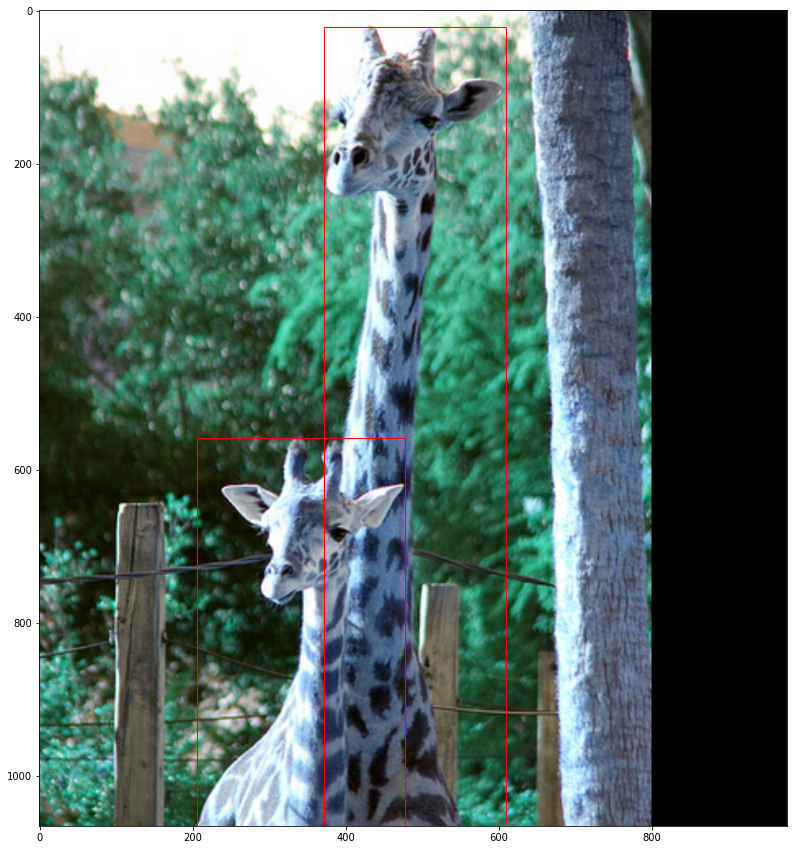

In [11]:
from kerod.utils.drawing import BoxDrawer, draw_bounding_boxes
    
for i, (features, gt) in enumerate(ds_train):
    draw_bounding_boxes(features['images'][0],
                gt['bbox'][0],
                resize=False)
    if i==10:
        break

In [9]:
i

0

# Load and train the network

Perfom an overfit

In [39]:
import tensorflow_addons as tfa

def downscale_backbone_grads(grads_and_vars):
    """Allow to decrease the gradients by 0.1 for the backbone like in the paper.
    Decreasing the gradients is equivalent to decreasing the learning rate by 0.1
    """
    variables_backbone = {var.name for var in detr.backbone.trainable_variables}
    outputs = []
    for g, v in grads_and_vars:
        if v.name in variables_backbone:
            outputs.append((tf.multiply(g, 0.1), v))
        else:
            outputs.append((g, v))
    return outputs

def clip_norm_grads(grads_and_vars):
    return [(tf.clip_by_norm(g, 0.1), v) for g, v in grads_and_vars]

optimizer = tfa.optimizers.AdamW(
    weight_decay=1e-4,
    learning_rate=1e-4,
    gradient_transformers=[downscale_backbone_grads, clip_norm_grads]
)

In [40]:
from kerod.core.standard_fields import BoxField
from kerod.model import factory
from kerod.model.factory import KerodModel
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

# Number of classes of Pascal Voc
classes = ds_info.features['objects']['label'].names
num_classes = len(classes)

detr = factory.build_model(num_classes, name=KerodModel.detr_resnet50)
detr.compile(optimizer=optimizer, loss=None)

In [41]:
classes

['person',
 'bicycle',
 'car',
 'motorcycle',
 'airplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'couch',
 'potted plant',
 'bed',
 'dining table',
 'toilet',
 'tv',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

## Graph mode 

In [ ]:
detr.fit(ds_train, epochs=200)

## Eager mode 

In [ ]:
# Allows to iterate eager mode
detr.run_eagerly = True

ds = [ds for ds in ds_train]
for _ in range(300):
    detr.train_step(ds[0])

## Visualize overfit

In [ ]:
from kerod.utils.drawing import BoxDrawer, draw_bounding_boxes

drawer = BoxDrawer(classes)

for example in ds_train:
    boxes, scores, labels = detr.predict_on_batch(example[0])
    drawer(
        example[0]['images'],
        example[0]['images_information'],
        boxes,
        scores=scores,
        labels=labels,
        num_valid_detections=[10 for _ in range(batch_size)]
    )
    draw_bounding_boxes(example[0]['images'][0],
                example[1]['bbox'][0],
                resize=False)